# Analysis of classification results

Objective: read back in the classification results and compare to original model

In [1]:
from IPython.core.display import HTML
css_file = 'pynoddy.css'
HTML(open(css_file, "r").read())

In [21]:
import sys, os
import matplotlib.pyplot as plt
# adjust some settings for matplotlib
from matplotlib import rcParams
# print rcParams
rcParams['font.size'] = 15
# determine path of repository to set paths corretly below
repo_path = os.path.realpath('../..')
import pynoddy.history
import numpy as np

In [3]:
%matplotlib inline

Load original model:

In [5]:
import pynoddy.output
reload(pynoddy.output)
output_name = "feature_out"
nout = pynoddy.output.NoddyOutput(output_name)

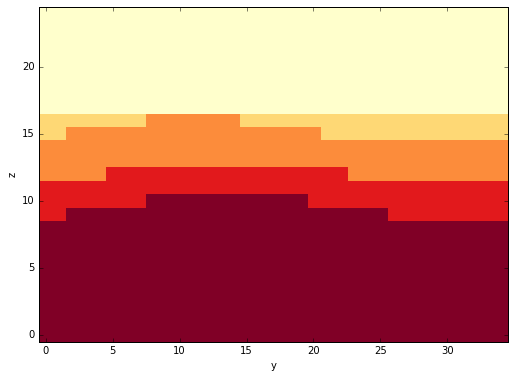

In [7]:
nout.plot_section('x', 
                  colorbar = True, title="",
                  savefig = False, fig_filename = "ex01_faults_combined.eps",
                  cmap = 'YlOrRd') # note: YlOrRd colourmap should be suitable for colorblindness!

## Load sample classification results

The implemented classification method does not return a single best-fit model, but an ensemble of probable model (as it is an MCMC sampling from the posterior). As a first test, we will therefore import single models first and check the misclassification rate defined as:

$$\mbox{MCR} = \frac{\mbox{Number of misclassified voxels}}{\mbox{Total number of voxels}}$$

In [139]:
f_set1 = open("../../sandbox/jack/features_lowres-5 with class ID.csv").readlines()

In [140]:
f_set1[0]

'x, y, z, f1, f2, f3,ID\n'

In [141]:
# initialise classification results array
cf1 = np.empty_like(nout.block)

In [142]:
# iterate through results and append
for f in f_set1[1:]:
    fl = f.rstrip().split(",")
    cf1[int(fl[0]),int(fl[1]),int(fl[2])] = int(fl[6])

In [143]:
f_set1[2:6]

['1,0,0,1.99307,5.07239,0.93235,2\n',
 '2,0,0,1.80728,5.09784,1.1543,2\n',
 '3,0,0,1.64958,5.04218,1.30599,2\n',
 '4,0,0,1.53292,5.13074,0.91244,2\n']

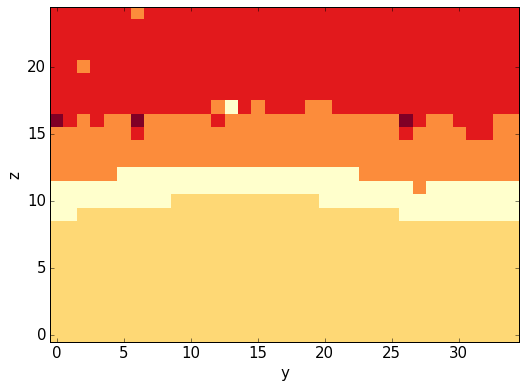

In [144]:
nout.plot_section('x', data = cf1,
                  colorbar = True, title="", layer_labels = range(5),
                  savefig = False, fig_filename = "ex01_faults_combined.eps",
                  cmap = 'YlOrRd') 

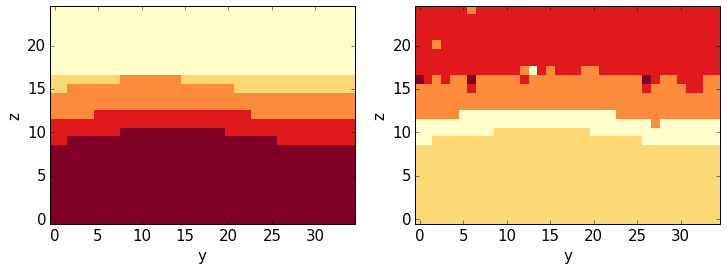

In [146]:
# compare to original model:
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
nout.plot_section('x', ax = ax1, 
                  colorbar = False, title="",
                  savefig = False, fig_filename = "ex01_faults_combined.eps",
                  cmap = 'YlOrRd') # note: YlOrRd colourmap should be suitable for colorblindness!
nout.plot_section('x', data = cf1,ax = ax2,
                  colorbar = False, title="",
                  savefig = False, fig_filename = "ex01_faults_combined.eps",
                  cmap = 'YlOrRd') 

Results of the classification do not necessarily contain the same ids as the units in the initial model. This seems to be the case here, as well. Re-sort:

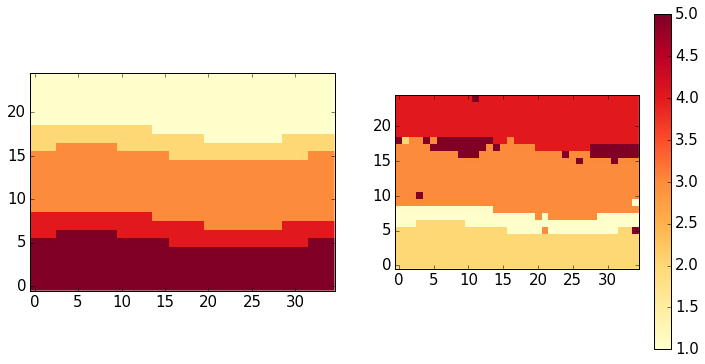

In [147]:
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
im1 = ax1.imshow(nout.block[15,:,:].transpose(), 
           interpolation = 'none', cmap = 'YlOrRd', origin = 'lower left')
plt.colorbar(im1)
im2 = ax2.imshow(cf1[15,:,:].transpose(), 
           interpolation = 'none', 
           cmap = 'YlOrRd', origin = 'lower left')

In [148]:
print np.unique(nout.block)
print np.unique(cf1)
# define id mapping from cluster results to original:
# id_mapping = {2:1, 3:2, 4:5, 5:3, 1:4}
# remapping for result 4:
# id_mapping = {4:5, 3:4, 1:3, 5:2, 2:1}
# remapping for result 5:
id_mapping = {2:5, 1:4, 3:3, 5:2, 4:1}

[ 1.  2.  3.  4.  5.]
[ 1.  2.  3.  4.  5.]


Now remap results and compare again:

**Note**: create a vectorised function to enable a direct re-mapping of the entire array while keeping the structure!

In [149]:
def re_map(id_val):
    return id_mapping[id_val]

In [150]:
re_map_vect = np.vectorize(re_map)

In [151]:
cf1_remap = re_map_vect(cf1)

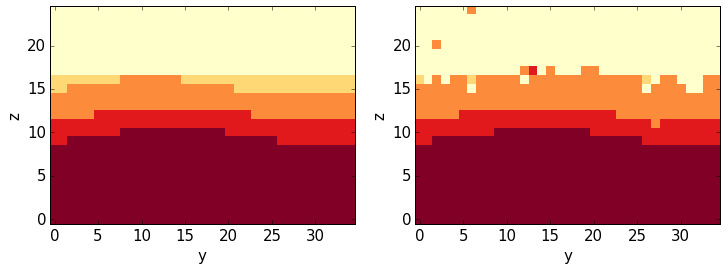

In [152]:
# compare to original model:
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
nout.plot_section('x', ax = ax1, 
                  colorbar = False, title="",
                  savefig = False, fig_filename = "ex01_faults_combined.eps",
                  cmap = 'YlOrRd') # note: YlOrRd colourmap should be suitable for colorblindness!
nout.plot_section('x', data = cf1_remap, ax = ax2,
                  colorbar = False, title="",
                  savefig = False, fig_filename = "ex01_faults_combined.eps",
                  cmap = 'YlOrRd') 

In [153]:
feature_diff = (nout.block != cf1_remap)

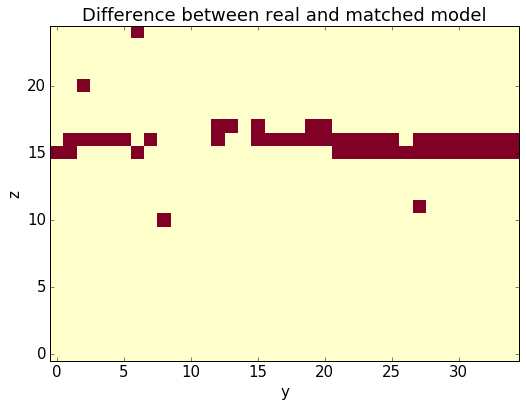

In [154]:
nout.plot_section('x', data = feature_diff,
                  colorbar = False, title="Difference between real and matched model",
                  cmap = 'YlOrRd') 

In [155]:
# Calculate the misclassification:
np.sum(feature_diff) / float(nout.n_total)

0.059177142857142859

In [156]:
# Export misclassification to VTK:
misclass = feature_diff.astype('int')

In [157]:
nout.export_to_vtk(vtk_filename = "misclass", data=misclass)

## Combined analysis in a single function

*Note*: function assumes correct EOL character in data file (check/ adjust with vi: %s/\r/\r/g)

**Problem**: remapping is unfortunatley not identical!

In [132]:
def calc_misclassification(nout, filename):
    """Calculate misclassification for classification results data stored in file
    
    **Arguments**:
        - *nout* = NoddyOutput: original model (Noddy object)
        - *filename* = filename (with path): file with classification results
    """
    f_set1 = open(filename).readlines()
    # initialise classification results array
    cf1 = np.empty_like(nout.block)
    # iterate through results and append
    for f in f_set1[1:]:
        fl = f.rstrip().split(",")
        cf1[int(fl[0]),int(fl[1]),int(fl[2])] = int(fl[6])
    # remap ids
    cf1_remap = re_map_vect(cf1)
    # determine differences in class ids:
    feature_diff = (nout.block != cf1_remap)
    # Calculate the misclassification:
    misclass = np.sum(feature_diff) / float(nout.n_total)
    return misclass

In [138]:
filename = r"../../sandbox/jack/features_lowres-4 with class ID.csv"
calc_misclassification(nout, filename)

0.09332571428571429

## Determine validity of uncertainty estimate

In addition to single model realisations, an esitmate of model uncertainty is calculated (this is, actually, also one of the main "selling points" of the paper). So, we will now check if the correct model is actually in the range of the estimated model uncertainty bounds (i.e.: if all voxets values from the original model actually have a non-zero probability in the estimated model)!

First step: load estimated class probabilities:

In [198]:
# f_set1 = open("../../sandbox/jack/features_lowres-6 with class ID and Prob.csv").readlines()
f_set1 = open("../../sandbox/jack/features_lowres-8 with Prob (weak Beta).csv").readlines()

In [199]:
f_set1[0]

'x, y, z, f1, f2, f3,P1,P2,P3,P4,P5\n'

In [200]:
# initialise classification results array
cf1 = np.empty_like(nout.block)

In [201]:
# Initialise probability array
probs = np.empty((5, cf1.shape[0], cf1.shape[1], cf1.shape[2]))

In [204]:
# iterate through results and append
for f in f_set1[1:]:
    fl = f.rstrip().split(",")
    i,j,k = int(fl[0]),int(fl[1]),int(fl[2])
    # cf1[i,j,k] = int(fl[6])
    for i2 in range(5):
        probs[i2,i,j,k] = float(fl[i2+6])

We now need to perform the remapping similar to before, but now for the probability fields:

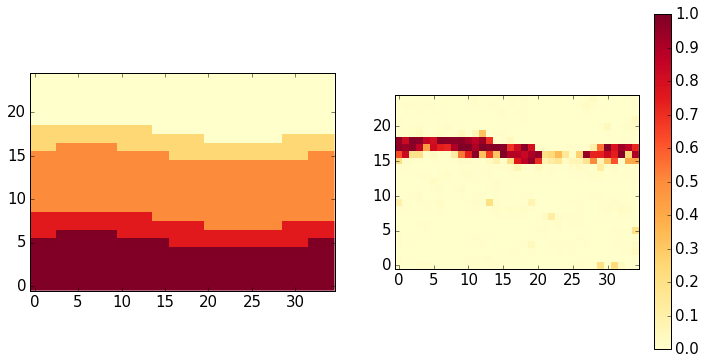

In [210]:
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
im1 = ax1.imshow(nout.block[15,:,:].transpose(), 
           interpolation = 'none', cmap = 'YlOrRd', origin = 'lower left')
plt.colorbar(im2)
im2 = ax2.imshow(probs[4,15,:,:].transpose(), 
           interpolation = 'none', 
           cmap = 'YlOrRd', origin = 'lower left')

In [211]:
# Note: map now ids from original model to probability fields in results:
prob_mapping = {4:0, 5:1, 3:2, 1:3, 2:4}

In [212]:
# Check membership for each class in original model
for i in range(1,6):
    tmp = np.ones_like(nout.block) * (nout.block==i)
    # test if voxels have non-zero probability by checking conjunction with zero-prob voxels
    prob_zero = probs[prob_mapping[i],:,:,:] == 0
    misidentified = np.sum(tmp * prob_zero)
    print i, misidentified
    

1 0.0
2 32.0
3 0.0
4 1.0
5 3.0


In [191]:
prob_zero = probs[prob_mapping[1],:,:,:] == 0

## Determination of misclassification statistics

Next step: use multiple results from one chain to determine misclassification statistics.

In [291]:
f_set1 = open("../../sandbox/jack/features_lowres-7 with 151 realizations.csv").readlines()

In [292]:
# Initialise results array
all_results = np.empty((152, cf1.shape[0], cf1.shape[1], cf1.shape[2]))

In [293]:
# iterate through results and append
for f in f_set1[1:]:
    fl = f.rstrip().split(",")
    i,j,k = int(fl[0]),int(fl[1]),int(fl[2])
    # cf1[i,j,k] = int(fl[6])
    for i2 in range(152):
        try:
            all_results[i2,i,j,k] = float(fl[i2+5])
        except IndexError:
            print i2, i, j, k

First, we again need to check the assignment of the units/ class ids:

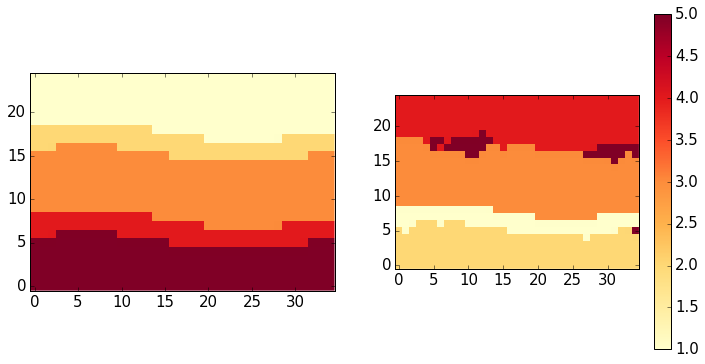

In [294]:
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
im1 = ax1.imshow(nout.block[15,:,:].transpose(), 
           interpolation = 'none', cmap = 'YlOrRd', origin = 'lower left')
plt.colorbar(im1)
im2 = ax2.imshow(all_results[5,15,:,:].transpose(), 
           interpolation = 'none', 
           cmap = 'YlOrRd', origin = 'lower left')

In [295]:
# mapping from results to original:
id_mapping = {2:5, 1:4, 3:3, 5:2, 4:1}

In [296]:
def re_map(id_val):
    return id_mapping[id_val]
re_map_vect = np.vectorize(re_map)

In [297]:
# Apply remapping to all but first result (seems to be original feature)
all_results_remap = re_map_vect(all_results[1:,:,:,:])

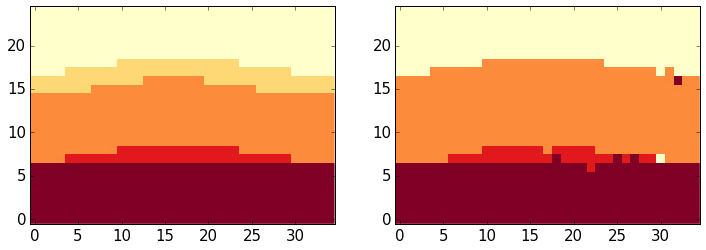

In [298]:
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
im1 = ax1.imshow(nout.block[30,:,:].transpose(), 
           interpolation = 'none', cmap = 'YlOrRd', origin = 'lower left')
# plt.colorbar(im1)
im2 = ax2.imshow(all_results_remap[85,30,:,:].transpose(), 
           interpolation = 'none', 
           cmap = 'YlOrRd', origin = 'lower left')

We can now determine the misclassification for all results:

In [299]:
all_misclass = np.empty(151)
for i in range(151):
    # determine differences in class ids:
    feature_diff = (nout.block != all_results_remap[i,:,:,:])
    # Calculate the misclassification:
    all_misclass[i] = np.sum(feature_diff) / float(nout.n_total)


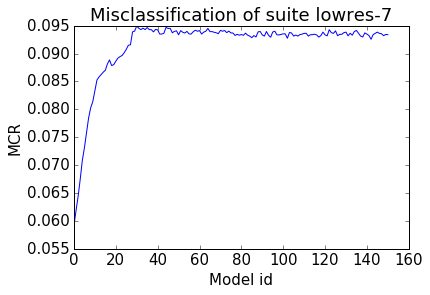

In [301]:
plt.plot(all_misclass)
plt.title("Misclassification of suite lowres-7")
plt.xlabel("Model id")
plt.ylabel("MCR")

It seems to be the case that the upper thin layer vanishes after approimately 30-40 iterations. From then on, the misclassification rate is approximately constant at around 9.5 percent (which is still quite acceptable!).

Let's compare this now to classifications with another (lower) beta value (which should put more weight to the data?):

In [276]:
f_set1 = open("../../sandbox/jack/features_lowres-9 with 151 realizations.csv").readlines()

In [277]:
# Initialise results array
all_results = np.empty((151, cf1.shape[0], cf1.shape[1], cf1.shape[2]))

In [278]:
# iterate through results and append
for f in f_set1[1:]:
    fl = f.rstrip().split(",")
    i,j,k = int(fl[0]),int(fl[1]),int(fl[2])
    # cf1[i,j,k] = int(fl[6])
    for i2 in range(151):
        try:
            all_results[i2,i,j,k] = float(fl[i2+6])
        except IndexError:
            print i2, i, j, k

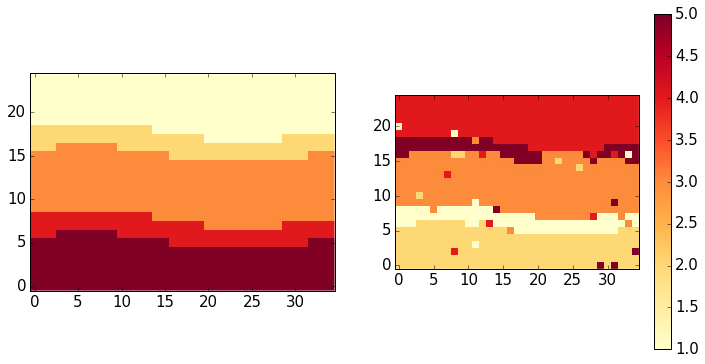

In [279]:
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
im1 = ax1.imshow(nout.block[15,:,:].transpose(), 
           interpolation = 'none', cmap = 'YlOrRd', origin = 'lower left')
plt.colorbar(im1)
im2 = ax2.imshow(all_results[20,15,:,:].transpose(), 
           interpolation = 'none', 
           cmap = 'YlOrRd', origin = 'lower left')

In [280]:
# define re-mapping
id_mapping = {2:5, 1:4, 3:3, 5:2, 4:1}

In [281]:
# Apply remapping to all but first result (seems to be original feature)
all_results_remap = re_map_vect(all_results[1:,:,:,:])

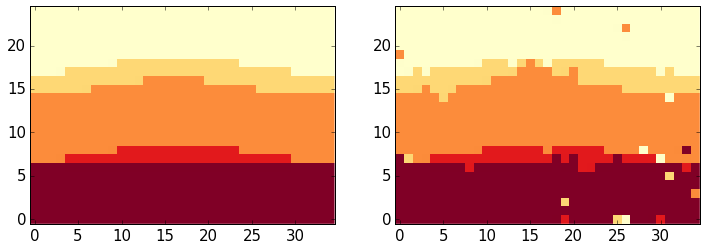

In [287]:
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
im1 = ax1.imshow(nout.block[30,:,:].transpose(), 
           interpolation = 'none', cmap = 'YlOrRd', origin = 'lower left')
# plt.colorbar(im1)
im2 = ax2.imshow(all_results_remap[115,30,:,:].transpose(), 
           interpolation = 'none', 
           cmap = 'YlOrRd', origin = 'lower left')

In [284]:
all_misclass = np.empty(150)
for i in range(150):
    # determine differences in class ids:
    feature_diff = (nout.block != all_results_remap[i,:,:,:])
    # Calculate the misclassification:
    all_misclass[i] = np.sum(feature_diff) / float(nout.n_total)


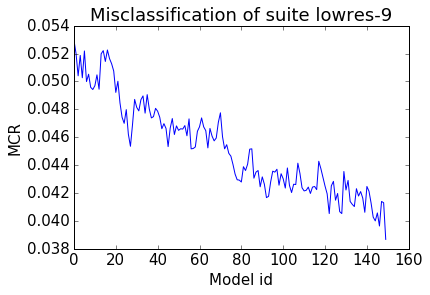

In [289]:
plt.plot(all_misclass)
plt.title("Misclassification of suite lowres-9")
plt.xlabel("Model id")
plt.ylabel("MCR")

In [302]:
f_set1 = open("../../sandbox/jack/features_lowres-10 with 2000 realizations.csv").readlines()

In [303]:
# Initialise results array
all_results = np.empty((2000, cf1.shape[0], cf1.shape[1], cf1.shape[2]))

In [304]:
# iterate through results and append
for f in f_set1[1:]:
    fl = f.rstrip().split(",")
    i,j,k = int(fl[0]),int(fl[1]),int(fl[2])
    # cf1[i,j,k] = int(fl[6])
    for i2 in range(2000):
        try:
            all_results[i2,i,j,k] = float(fl[i2+6])
        except IndexError:
            print i2, i, j, k

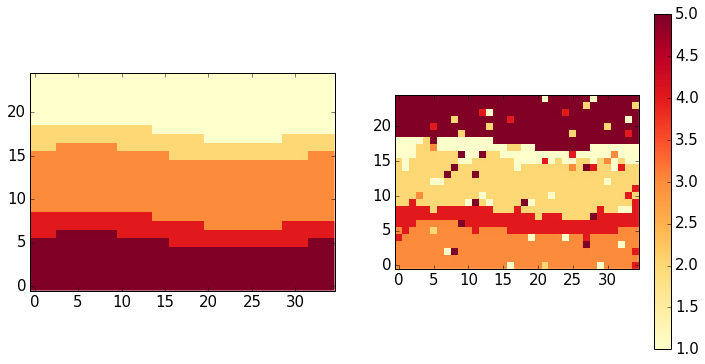

In [305]:
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
im1 = ax1.imshow(nout.block[15,:,:].transpose(), 
           interpolation = 'none', cmap = 'YlOrRd', origin = 'lower left')
plt.colorbar(im1)
im2 = ax2.imshow(all_results[20,15,:,:].transpose(), 
           interpolation = 'none', 
           cmap = 'YlOrRd', origin = 'lower left')

In [318]:
# define re-mapping
id_mapping = {3:5, 4:4, 2:3, 1:2, 5:1, 0:0}

In [319]:
# Apply remapping to all but first result (seems to be original feature)
all_results_remap = re_map_vect(all_results[2:,:,:,:])

In [313]:
np.unique(all_results[1999,:,:,:])

array([ 0.,  1.,  2.,  3.,  4.,  5.])

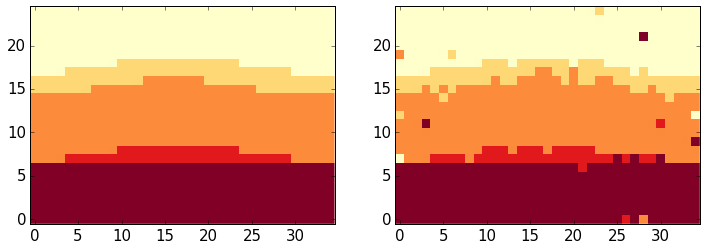

In [320]:
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
im1 = ax1.imshow(nout.block[30,:,:].transpose(), 
           interpolation = 'none', cmap = 'YlOrRd', origin = 'lower left')
# plt.colorbar(im1)
im2 = ax2.imshow(all_results_remap[115,30,:,:].transpose(), 
           interpolation = 'none', 
           cmap = 'YlOrRd', origin = 'lower left')

In [322]:
all_misclass = np.empty(1998)
for i in range(1998):
    # determine differences in class ids:
    feature_diff = (nout.block != all_results_remap[i,:,:,:])
    # Calculate the misclassification:
    all_misclass[i] = np.sum(feature_diff) / float(nout.n_total)



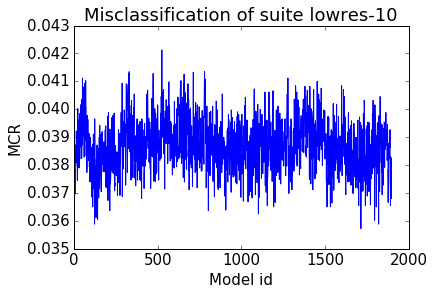

In [327]:
plt.plot(all_misclass[100:])
plt.title("Misclassification of suite lowres-10")
plt.xlabel("Model id")
plt.ylabel("MCR")

(array([   8.,   42.,  177.,  432.,  494.,  418.,  230.,   75.,   21.,    1.]),
 array([ 0.03572571,  0.03636571,  0.03700571,  0.03764571,  0.03828571,
         0.03892571,  0.03956571,  0.04020571,  0.04084571,  0.04148571,
         0.04212571]),
 <a list of 10 Patch objects>)

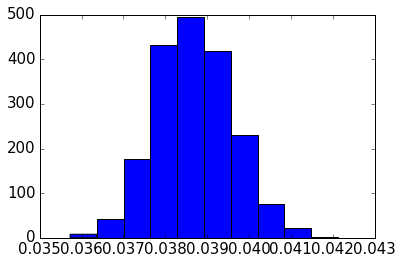

In [328]:
plt.hist(all_misclass[100:])

## Determine validity of estimated probability


In [332]:
# f_set1 = open("../../sandbox/jack/features_lowres-6 with class ID and Prob.csv").readlines()
f_set1 = open("../../sandbox/jack/features_lowres-10 with Prob (weak Beta).csv").readlines()

In [333]:
# initialise classification results array
cf1 = np.empty_like(nout.block)

In [334]:
f_set1[0]

'x, y, z, f1, f2, f3,P1,P2,P3,P4,P5\n'

In [335]:
# Initialise probability array
probs = np.empty((5, cf1.shape[0], cf1.shape[1], cf1.shape[2]))

In [336]:
# iterate through results and append
for f in f_set1[1:]:
    fl = f.rstrip().split(",")
    i,j,k = int(fl[0]),int(fl[1]),int(fl[2])
    # cf1[i,j,k] = int(fl[6])
    for i2 in range(5):
        probs[i2,i,j,k] = float(fl[i2+6])

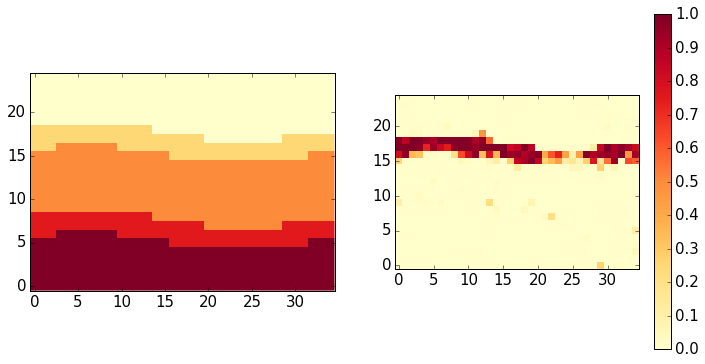

In [346]:
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
im1 = ax1.imshow(nout.block[15,:,:].transpose(), 
           interpolation = 'none', cmap = 'YlOrRd', origin = 'lower left')
plt.colorbar(im2)
im2 = ax2.imshow(probs[0,15,:,:].transpose(), 
           interpolation = 'none', 
           cmap = 'YlOrRd', origin = 'lower left')

In [344]:
# Note: map now ids from original model to probability fields in results:
prob_mapping = {2:0, 3:1, 5:2, 4:3, 1:4}

In [345]:
# Check membership for each class in original model
for i in range(1,6):
    tmp = np.ones_like(nout.block) * (nout.block==i)
    # test if voxels have non-zero probability by checking conjunction with zero-prob voxels
    prob_zero = probs[prob_mapping[i],:,:,:] == 0
    misidentified = np.sum(tmp * prob_zero)
    print i, misidentified
    

1 0.0
2 0.0
3 0.0
4 0.0
5 0.0


In [370]:
info_entropy = np.zeros_like(nout.block)

In [371]:
for prob in probs:
    info_entropy[prob > 0] -= prob[prob > 0] * np.log2(prob[prob > 0])


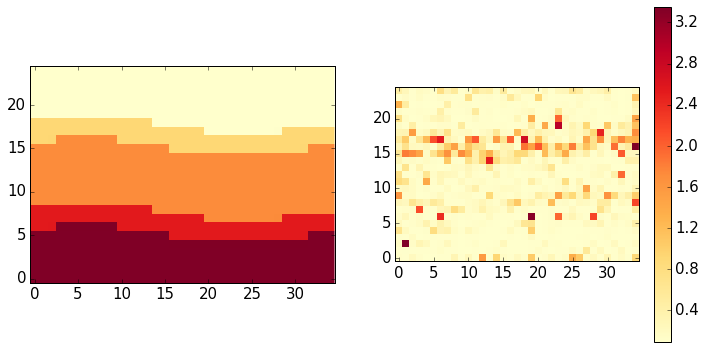

In [372]:
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
im1 = ax1.imshow(nout.block[15,:,:].transpose(), 
           interpolation = 'none', cmap = 'YlOrRd', origin = 'lower left')
plt.colorbar(im2)
im2 = ax2.imshow(info_entropy[1,:,:].transpose(), 
           interpolation = 'none', 
           cmap = 'YlOrRd', origin = 'lower left')

In [373]:
nout.export_to_vtk(vtk_filename = "../../sandbox/jack/info_entropy", data = info_entropy)

In [374]:
np.max(probs)

1.0

In [369]:
np.max(info_entropy)

nan